In [4]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_hub as hub
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [5]:
batch_size = 32
IMAGE_SHAPE = (224, 224)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str('figures'),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=batch_size)

Found 387 files belonging to 10 classes.
Using 310 files for training.


In [6]:
class_names = np.array(train_ds.class_names)
print(class_names)
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

['auto' 'circle' 'cross' 'hand' 'lion' 'rectangle' 'square' 'star'
 'tourtle' 'triangle']


In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

(32, 224, 224, 3)
(32,)
(32, 1280)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 10])

In [9]:
# Data Augmentation
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SHAPE[0],IMAGE_SHAPE[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [10]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Epoch 1/20
10/10 [==============================] - 4s 392ms/step - loss: 0.9567 - acc: 0.7727
Epoch 2/20
10/10 [==============================] - 5s 454ms/step - loss: 0.3093 - acc: 1.0000

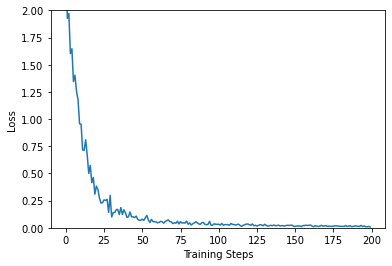

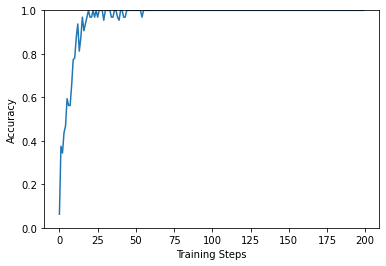

In [11]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(aug_ds, epochs=20,
                    callbacks=[batch_stats_callback])
                
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

3.7689686


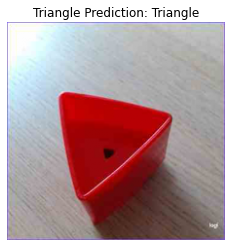

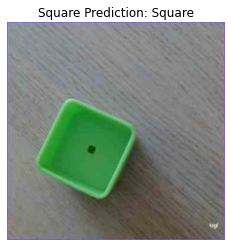

In [12]:
plt.figure()
test_image = 'figures/triangle/2021-04-15_15-59-40.jpg'
triangle = Image.open(test_image).resize(IMAGE_SHAPE)
triangle = np.array(triangle)/255.0
result = model.predict(triangle[np.newaxis, ...])
predicted_id = np.argmax(result, axis=-1)
predicted_label = class_names[predicted_id]
result.shape
plt.imshow(triangle)
plt.axis('off')
_ = plt.title("Triangle Prediction: " + predicted_label[0].title())

plt.figure()
test_image = 'figures/square/2021-04-15_15-52-12.jpg'
square = Image.open(test_image).resize(IMAGE_SHAPE)
square = np.array(square)/255.0
result = model.predict(square[np.newaxis, ...])
predicted_id = np.argmax(result, axis=-1)
predicted_label = class_names[predicted_id]
result.shape
print(np.max(result))
plt.imshow(square)
plt.axis('off')
_ = plt.title("Square Prediction: " + predicted_label[0].title())

In [13]:
#model.save_weights("figures_weights.h5")
model.save("figures_model")
#model_reconstructed = keras.models.load_model("figures_model")
#model.load_weights("weights.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: figures_model\assets


INFO:tensorflow:Assets written to: figures_model\assets


In [14]:
model_reconstructed = tf.keras.models.load_model("figures_model")

3.7689686


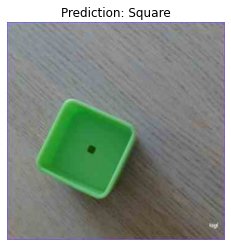

In [15]:
test_image = 'figures/square/2021-04-15_15-52-12.jpg'
square = Image.open(test_image).resize(IMAGE_SHAPE)
square = np.array(square)/255.0
result = model_reconstructed.predict(square[np.newaxis, ...])
predicted_id = np.argmax(result, axis=-1)
predicted_label = class_names[predicted_id]
result.shape
print(np.max(result))
plt.imshow(square)
plt.axis('off')
_ = plt.title("Prediction: " + predicted_label[0].title())